In [31]:
from tqdm import tqdm
import os
from os.path import exists
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [6]:
DATA_ROOT_DIR = '/proj/case/2025-06-05'
ALL_DIRS = os.listdir(DATA_ROOT_DIR)
EUCLID_DIRS = []
CASE_DIRS = []

TOTAL_FRAMES = 450

#### Grab all directories

In [7]:
!ls '/proj/case/2025-06-05'

'$RECYCLE.BIN'	    18274_Euclid_SCA   FPM_102_101   FPM_EM3_EM6_post_vibe
 18220_Euclid_SCA   18275_Euclid_SCA   FPM_102_105   FPM_EM3_EM6_pre_vibe
 18248_Euclid_SCA   18282_Euclid_SCA   FPM_104_103  'System Volume Information'
 18266_Euclid_SCA   18283_Euclid_SCA   FPM_EM1_EM2


In [8]:
for dir in ALL_DIRS:
    if 'Euclid' in dir:
        EUCLID_DIRS.append(dir)
    elif 'FPM' in dir:
        CASE_DIRS.append(dir)

print(f'Euclid test data directories: {EUCLID_DIRS}\n')
print(f'Case test data directories: {CASE_DIRS}')

Euclid test data directories: ['18220_Euclid_SCA', '18248_Euclid_SCA', '18266_Euclid_SCA', '18274_Euclid_SCA', '18275_Euclid_SCA', '18282_Euclid_SCA', '18283_Euclid_SCA']

Case test data directories: ['FPM_102_101', 'FPM_102_105', 'FPM_104_103', 'FPM_EM1_EM2', 'FPM_EM3_EM6_post_vibe', 'FPM_EM3_EM6_pre_vibe']


#### Preprocess the Data

In [27]:
class TrainingData:
    """

    """
    def __init__():
        """

        """


    def create_directory():
        """
            * basically create training set dir for preprocess to be stored as h5py
        """
        # Make the training set directory
        root = 'training_set'
        curr_dir = Path(root).mkdir(parents = True, exist_ok = True)

        # Make difference array directory
        Path(f'{root}/raw_differences').mkdir(parents = True, exist_ok = True)

        # Make patches directory
        Path(f'{root}/patches').mkdir(parents = True, exist_ok = True)

        # Make temporal analysis directory
        Path(f'{root}/temporal_analysis').mkdir(parents = True, exist_ok = True)


    def _preprocess(dataset_name):
        """
            * basically do the first frame subtraction
            * dataset_name = 'euclid' or 'case'
        """
        if dataset_name.upper() == 'EUCLID':
            print('ay')

        elif dataset_name.upper() == 'CASE':
            print('ay')

        else:
            raise ValueError(f'Invalid dataset name of {dataset_name.upper()}, must be EUCLUD or CASE')
        
    
    def _grab_filenames(path):
        """
            * basically grab all filenames for the current path
        """
        try:
            entries = os.listdir(path)
            filenames = [entry for entry in entries if os.path.isfile(os.path.join(path, entry))]
        
        except FileNotFoundError as e:
            print('Folder not found at {path}')
            return None
        
        return filenames
    

    def _subtract_ref_pixels(frame):
        """
            * perform ref pixel subtraction as documented in paper
                Reference Pixel Subtraction
                Method for EUCLID SCS Noise
                Specification
                Bogna Kubik
        """
        # Make sure shape is 2048 x 2048
        if frame.shape != (2048, 2048):
            raise ValueError(f'Invalid frame shape of {frame.shape}, must be (2048, 2048)')
        
        corrected_frame = frame.copy().astype(np.float64)

        # Optimal window side via paper
        x_opt = 64
        y_opt = 4

        # Reference pixel regions
        up_ref = frame[0:4, :] # Top 4 rows
        down_ref = frame[2044:2048, :] # Bottom 4 rows
        left_ref = frame[:, 0:4] # Left 4 cols
        right_ref = frame[:, 2044:2048]

        # Process each of the 32 channels
        for ch in range(32):
            # Skip left ref pixels
            if ch == 0:
                col_start, col_end = 4, 64
            
            # Skip right ref pixels
            elif ch == 31:
                col_start, col_end = ch * 64, 2044  # Fixed: clearer intent

            # Inner channels
            else:
                col_start, col_end = ch * 64, (ch + 1) * 64

            # Up/down correction w/ extract channel specific ref pixels 
            for col in range(col_end - col_start):
                global_col = col_start + col

                # Sliding window for up/down
                window_start = max(0, col_start)
                window_end = min(2048, col_end)

                # Average the up and down ref pixels
                up_avg = np.mean(up_ref[:, window_start:window_end])
                down_avg = np.mean(down_ref[:, window_start:window_end])

                # Interpolate correction
                slope = (up_avg - down_avg) / 2044

                # Apply correction to each row in the column, skipping refs
                for row in range(4, 2044):
                    ref_correction = down_avg + (row - 1.5) * slope
                    corrected_frame[row, global_col] -= ref_correction

        # Correct left ref pixel
        left_ref_corrected = left_ref.copy()
        right_ref_corrected = right_ref.copy()

        # Subtract the up/down correction from the left/right pixels
        up_avg_full = np.mean(up_ref)
        down_avg_full = np.mean(down_ref)
        slope_full = (up_avg_full - down_avg_full) / 2044

        # Fixed: Correct the left/right ref pixels with proper loop
        for row in range(4, 2044):
            ref_correction = down_avg_full + (row - 1.5) * slope_full
            left_ref_corrected[row, :] -= ref_correction
            right_ref_corrected[row, :] -= ref_correction

        # Apply the correction using sliding window
        for row in range(4, 2044):
            # Sliding window for left/right
            window_start = max(4, row - y_opt)
            window_end = min(2044, row + y_opt + 1)

            # Fixed: Average corrected left/right pixels (syntax error)
            left_avg = np.mean(left_ref_corrected[window_start:window_end, :])
            right_avg = np.mean(right_ref_corrected[window_start:window_end, :])  # Fixed the dot
            lr_correction = (left_avg + right_avg) / 2

            corrected_frame[row, 4:2044] -= lr_correction

        return corrected_frame
    
    
    def _compute_difference_fits(self, file_path):
        """
            * subtract frame 0 from the current fits file
        """
        frame_difs = []

        # Open the current fits file
        with fits.open(file_path) as hdul:
            # Grab frame 0
            frame_0 = hdul[1].data.astype(np.float64)

            # Subtract reference pixels
            frame_0 = self._subtract_ref_pixels(frame_0)

            # Iterate through all frames, skipping the first
            for i in tqdm(range(2, TOTAL_FRAMES)):
                # Grab the current frame
                curr_frame = hdul[i].data.astype(np.float64)
                curr_frame = self._subtract_ref_pixels(curr_frame)

                # Subtract from 0
                dif = np.abs(curr_frame - frame_0)
                frame_difs.append(dif)

        return np.array(frame_difs)
      
    def _euclid_preprocess(self):
        """

        """ 
        # Grab all euclid filenames
        for dir in EUCLID_DIRS:
            path = f'{DATA_ROOT_DIR}/{dir}'
            filenames = self._grab_filenames(path)

            for filename in filenames:
                # Create file path
                curr_path = f'{path}/{filename}'

                # Calculate the difference in frames
                frame_difs = self._compute_difference_fits(self, curr_path)

                return frame_difs
                break


            break

            # Iterate through all filenames


    def load():
        print('ay')



#### Testing

In [28]:
training = TrainingData
training.create_directory()

frame_difs = training._euclid_preprocess(training)

100%|██████████| 448/448 [18:37<00:00,  2.50s/it]


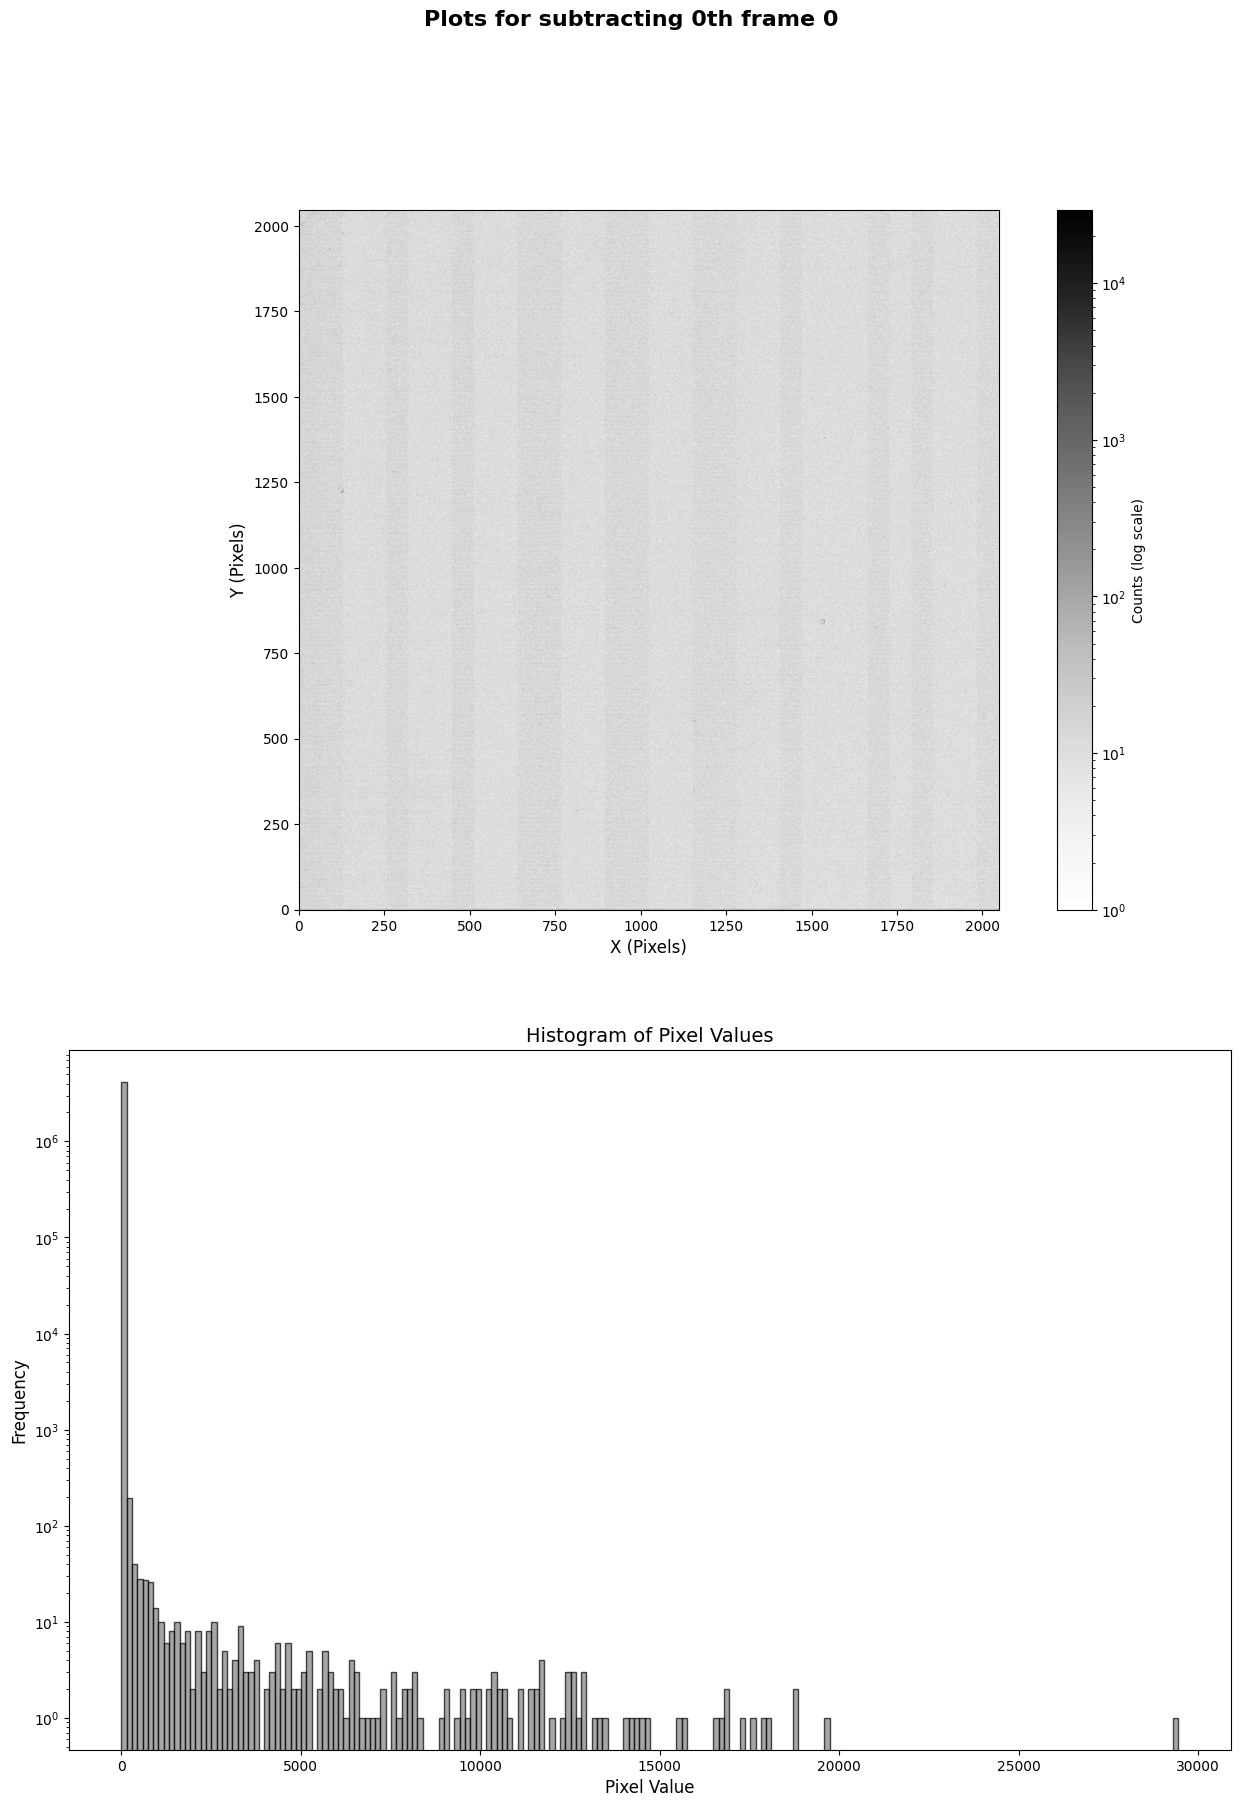

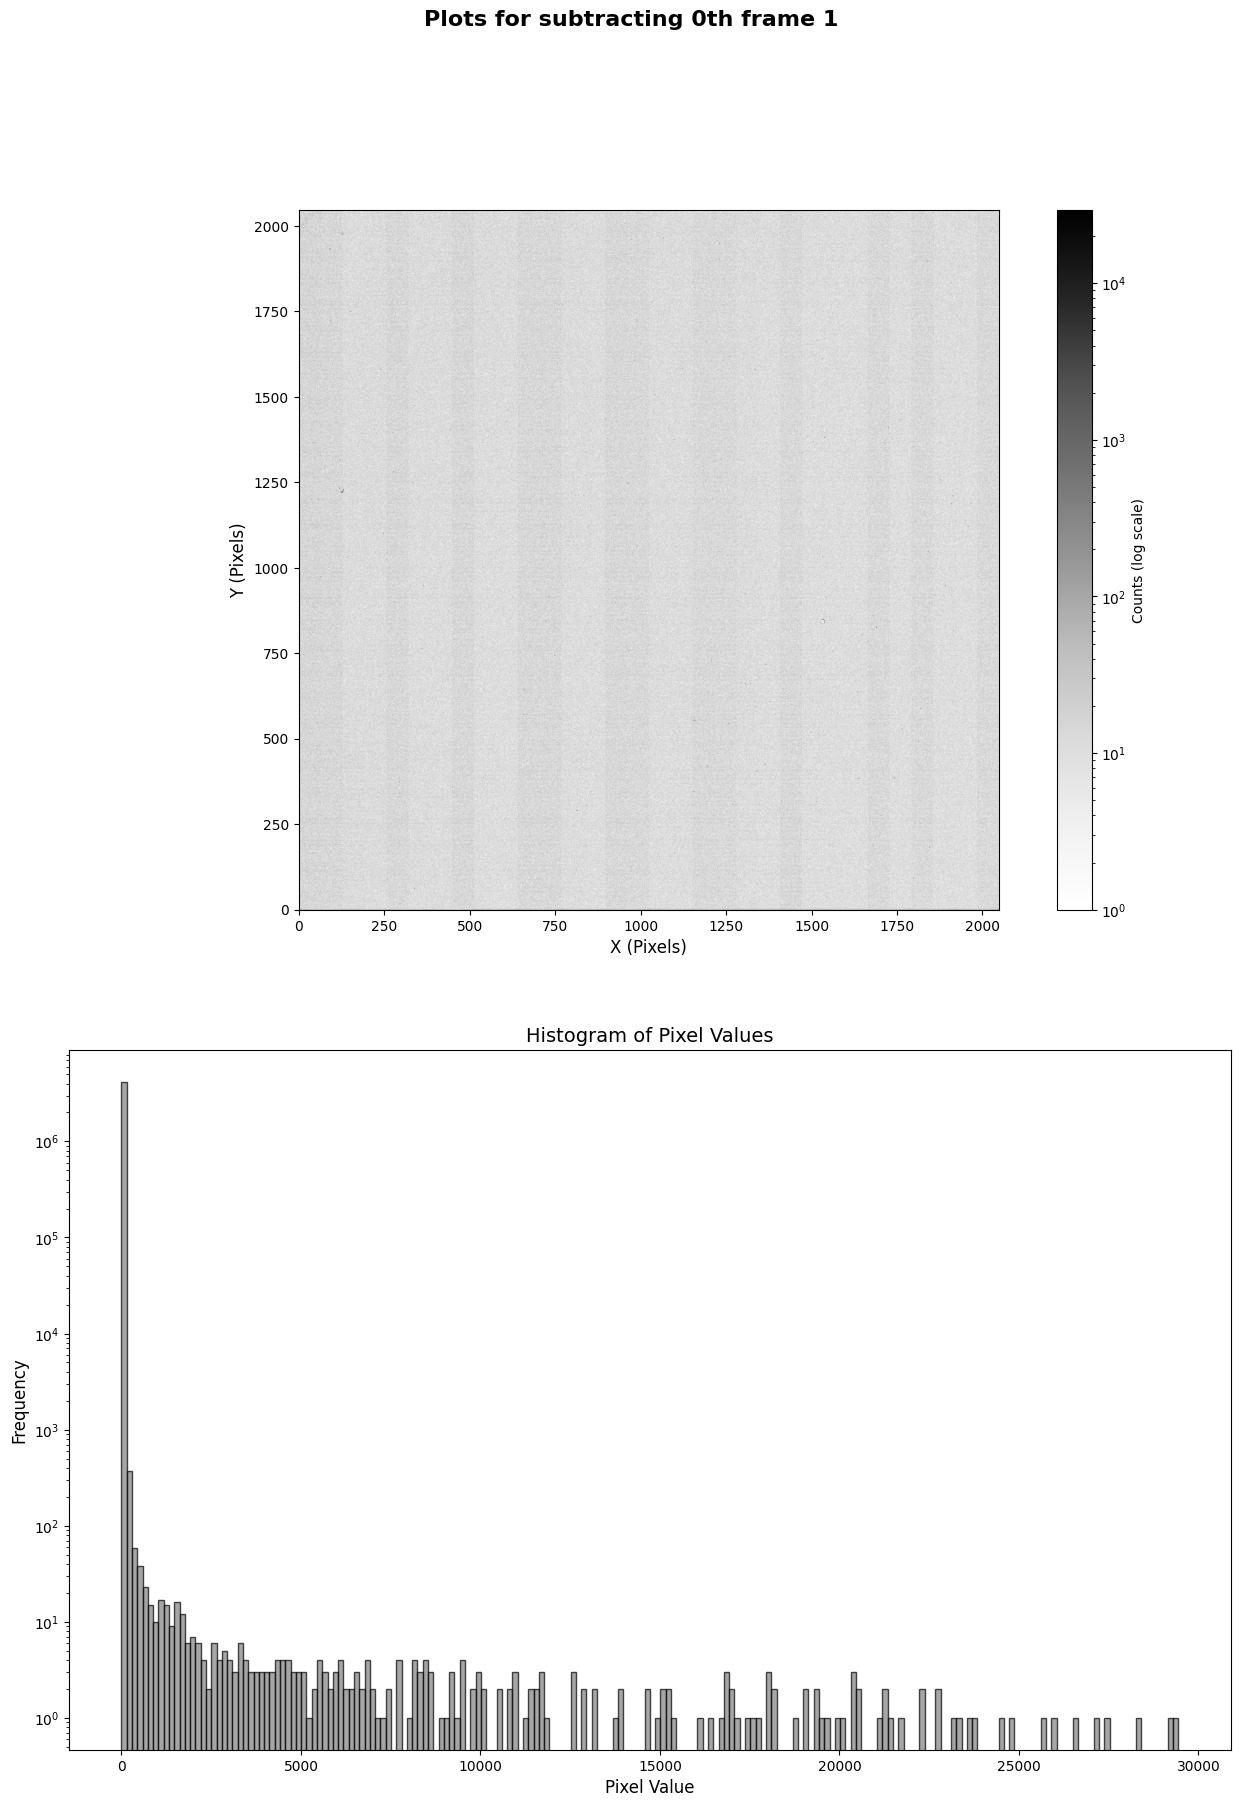

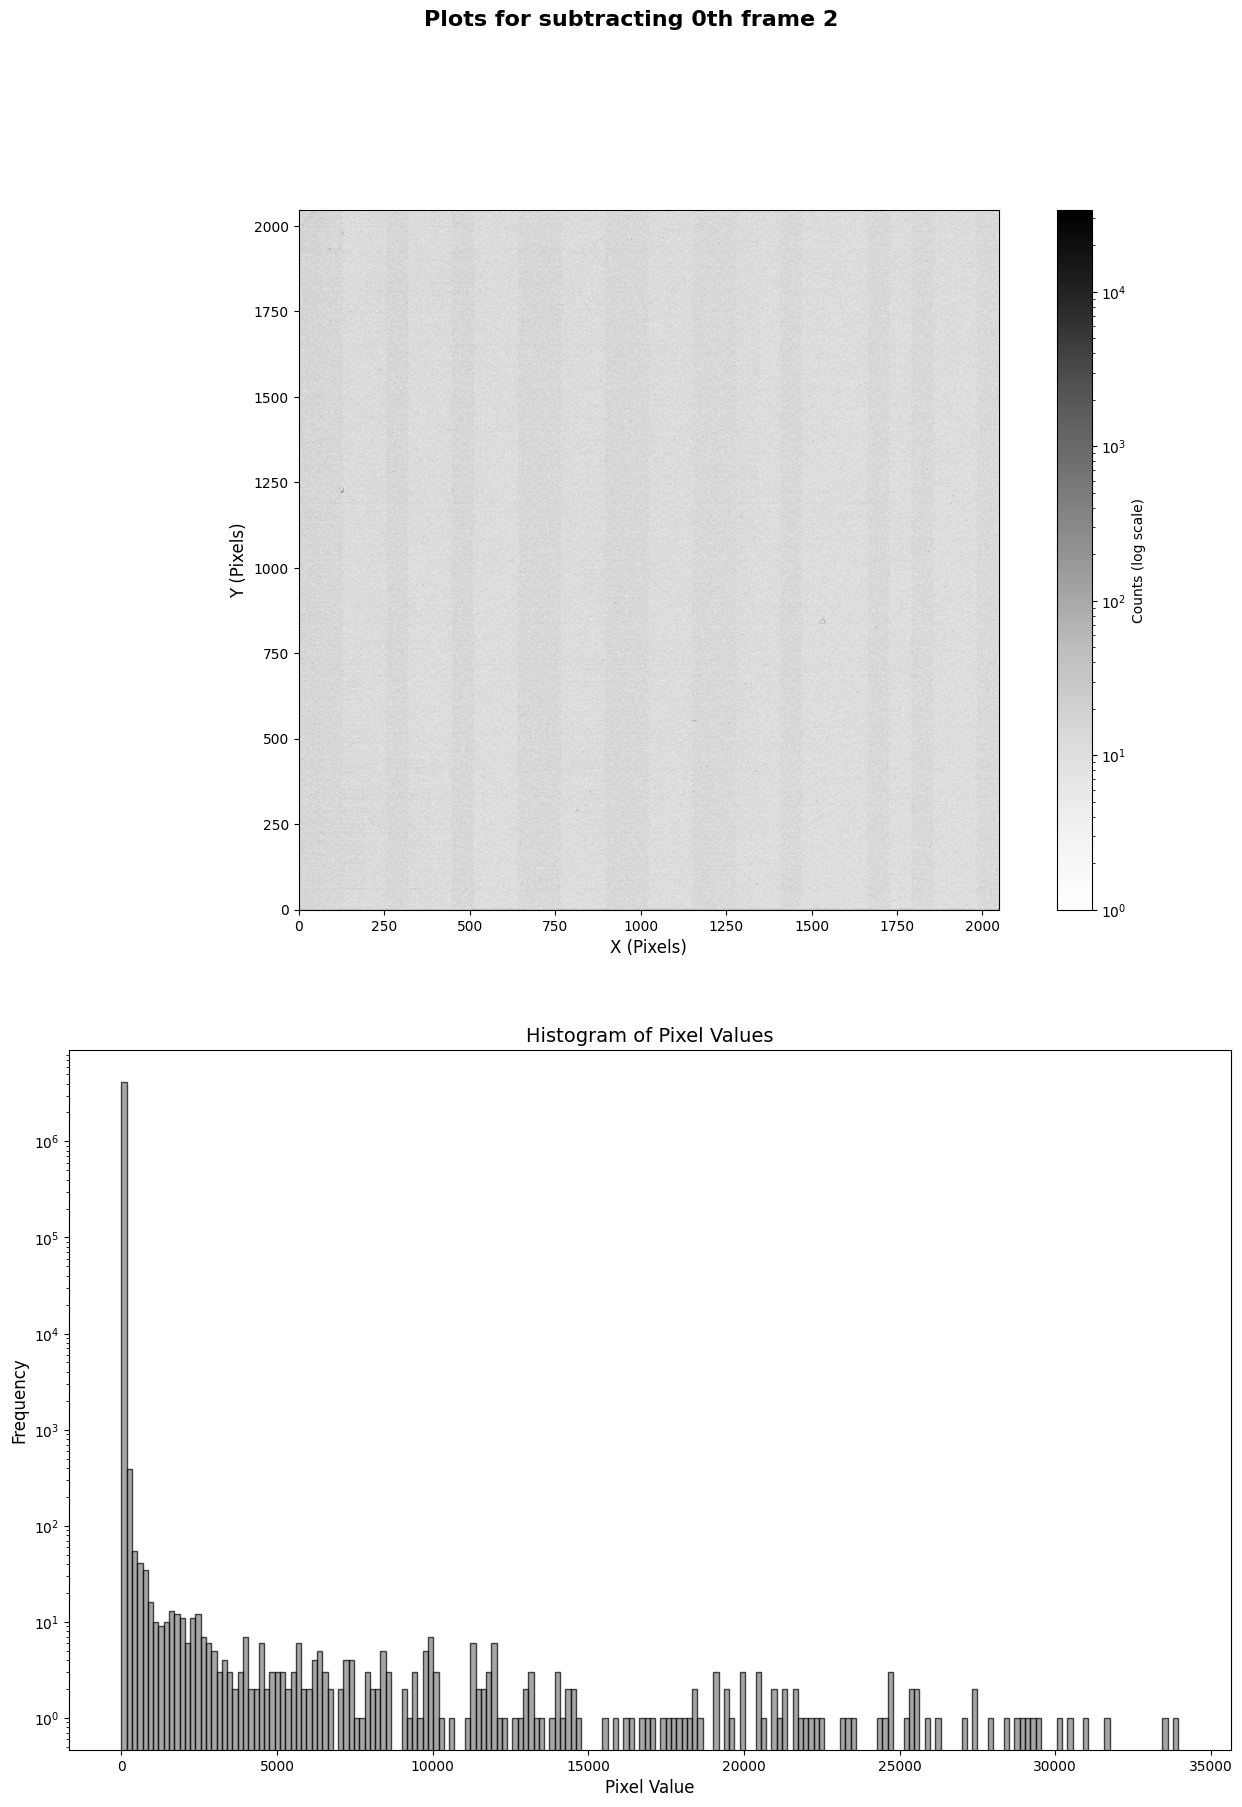

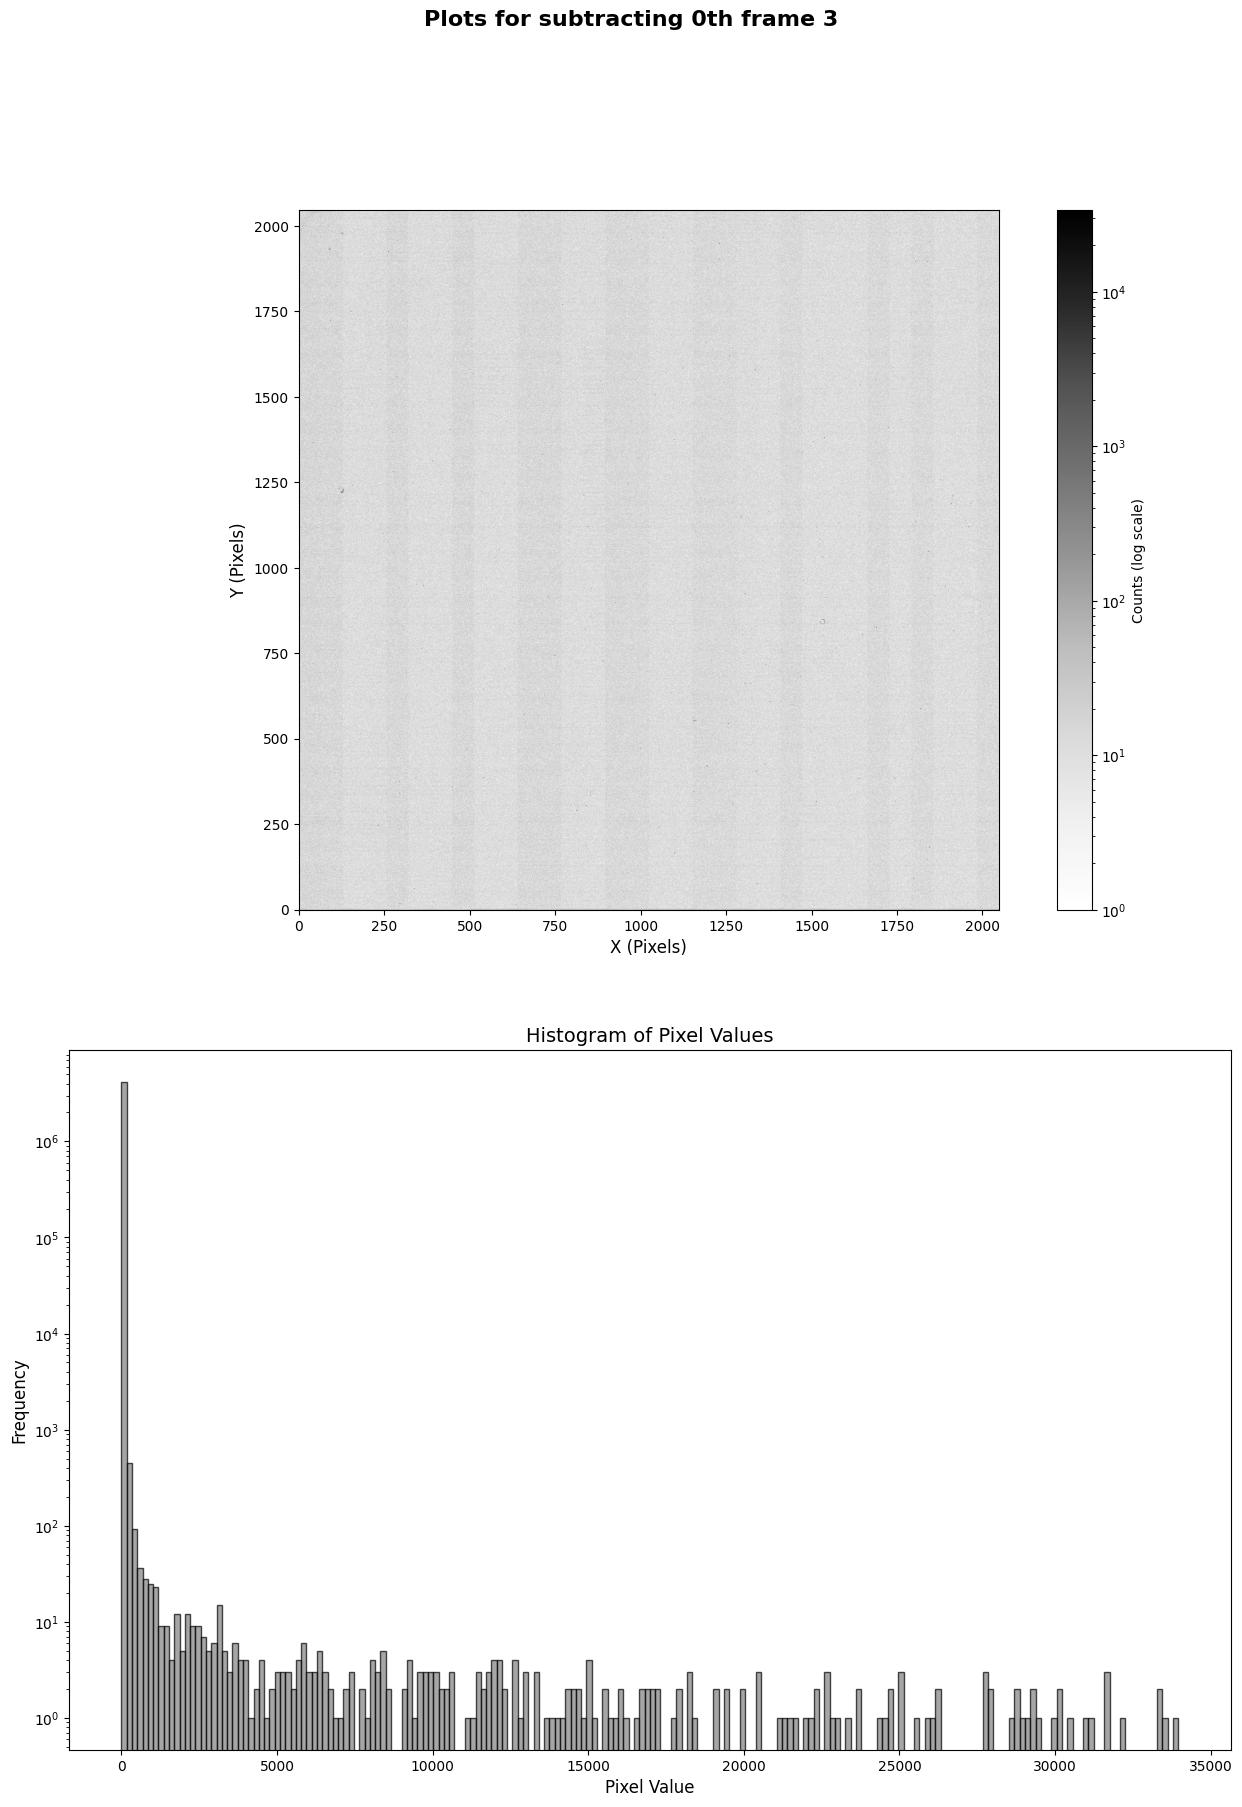

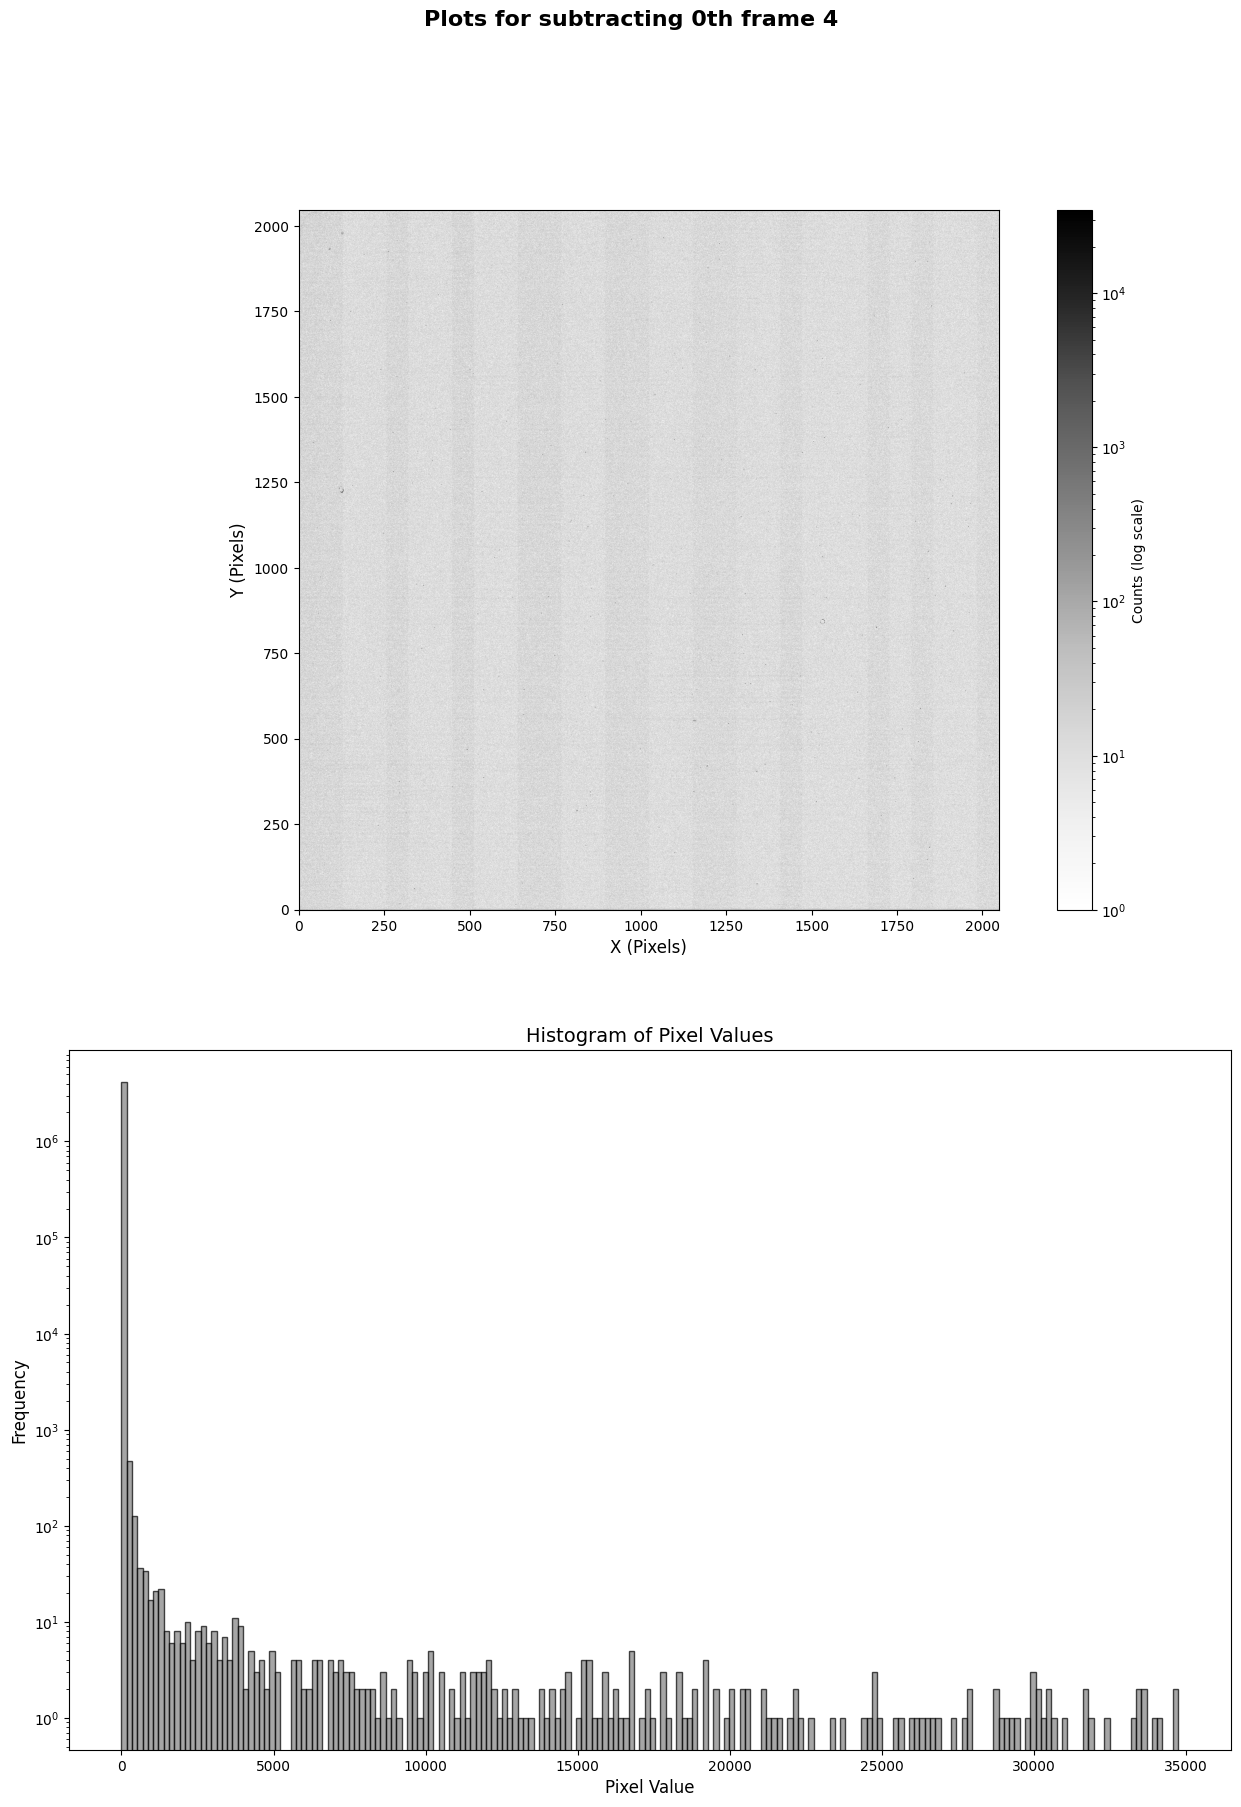

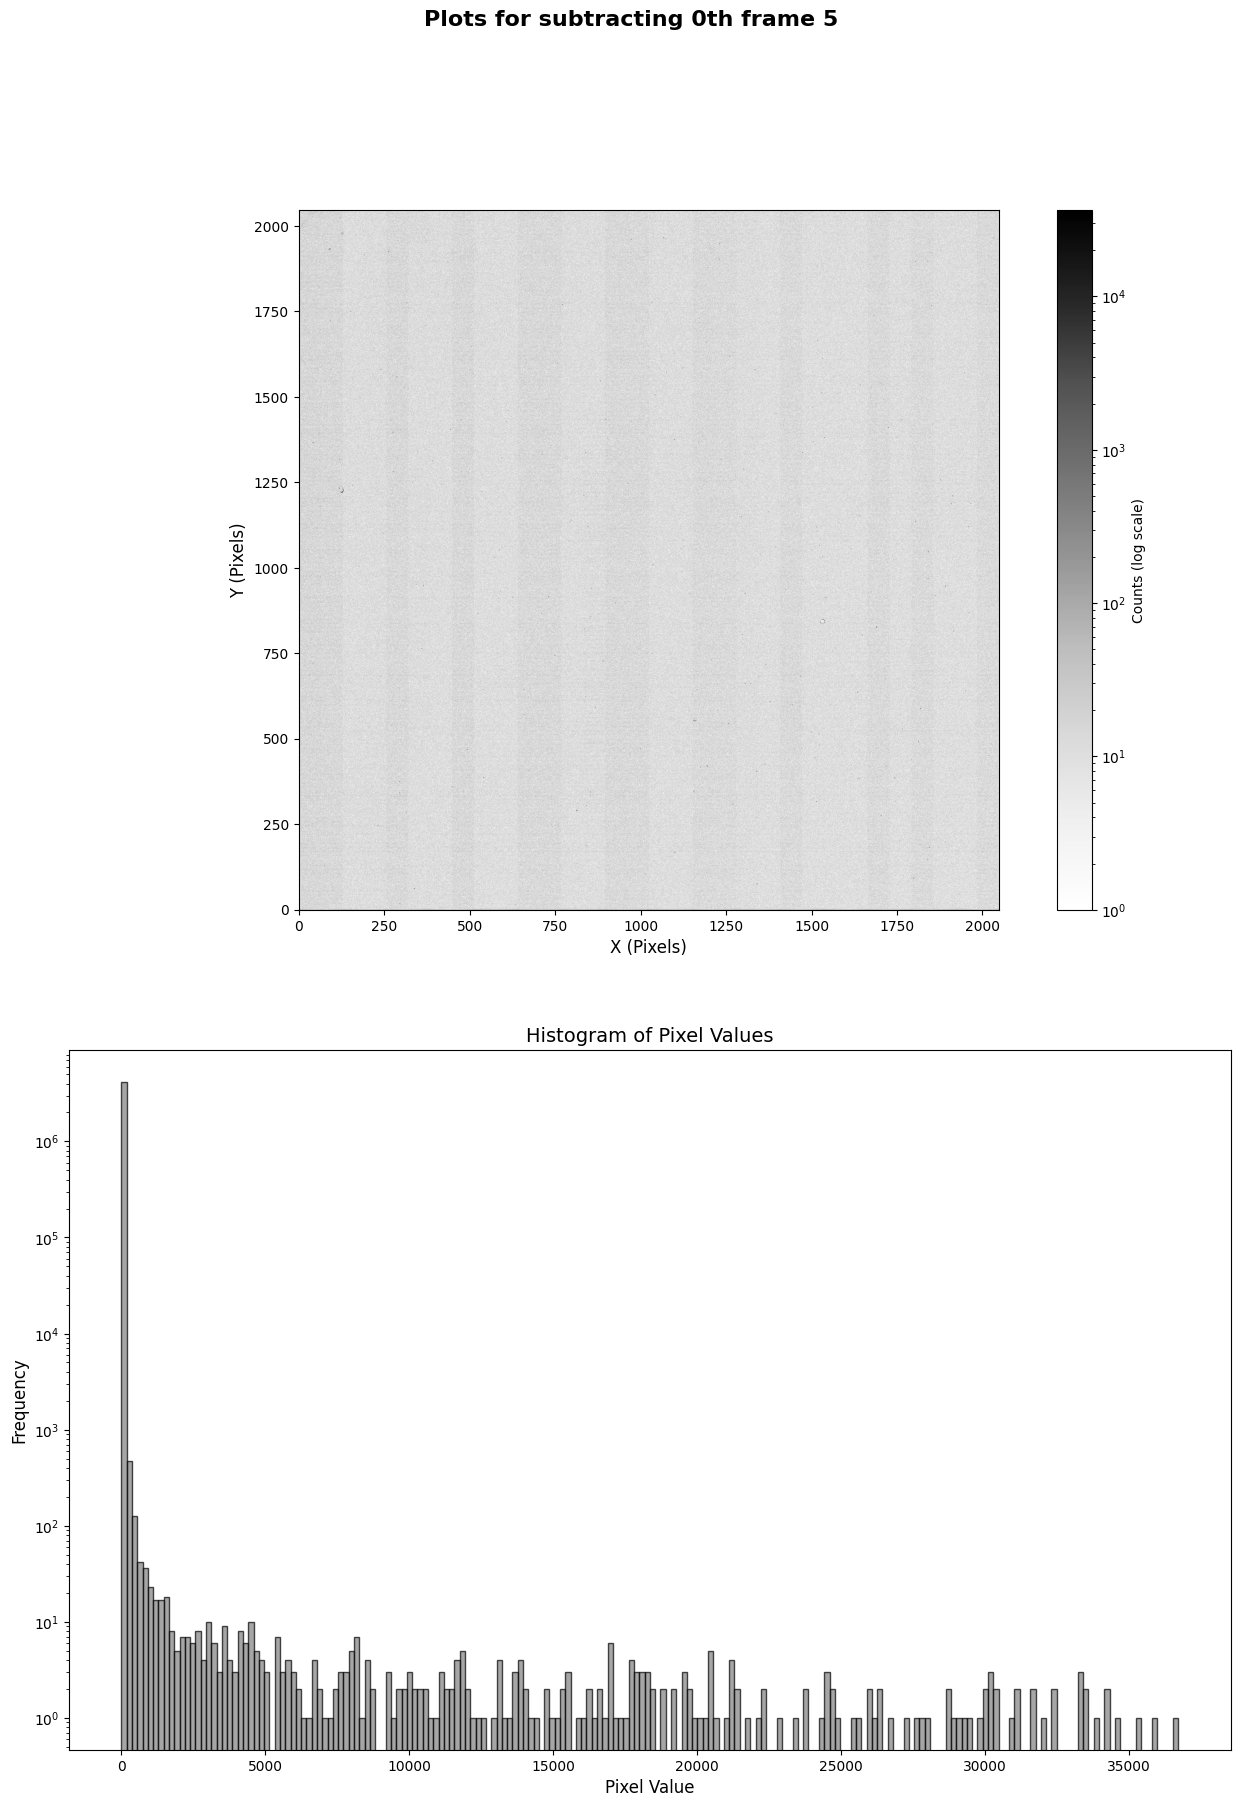

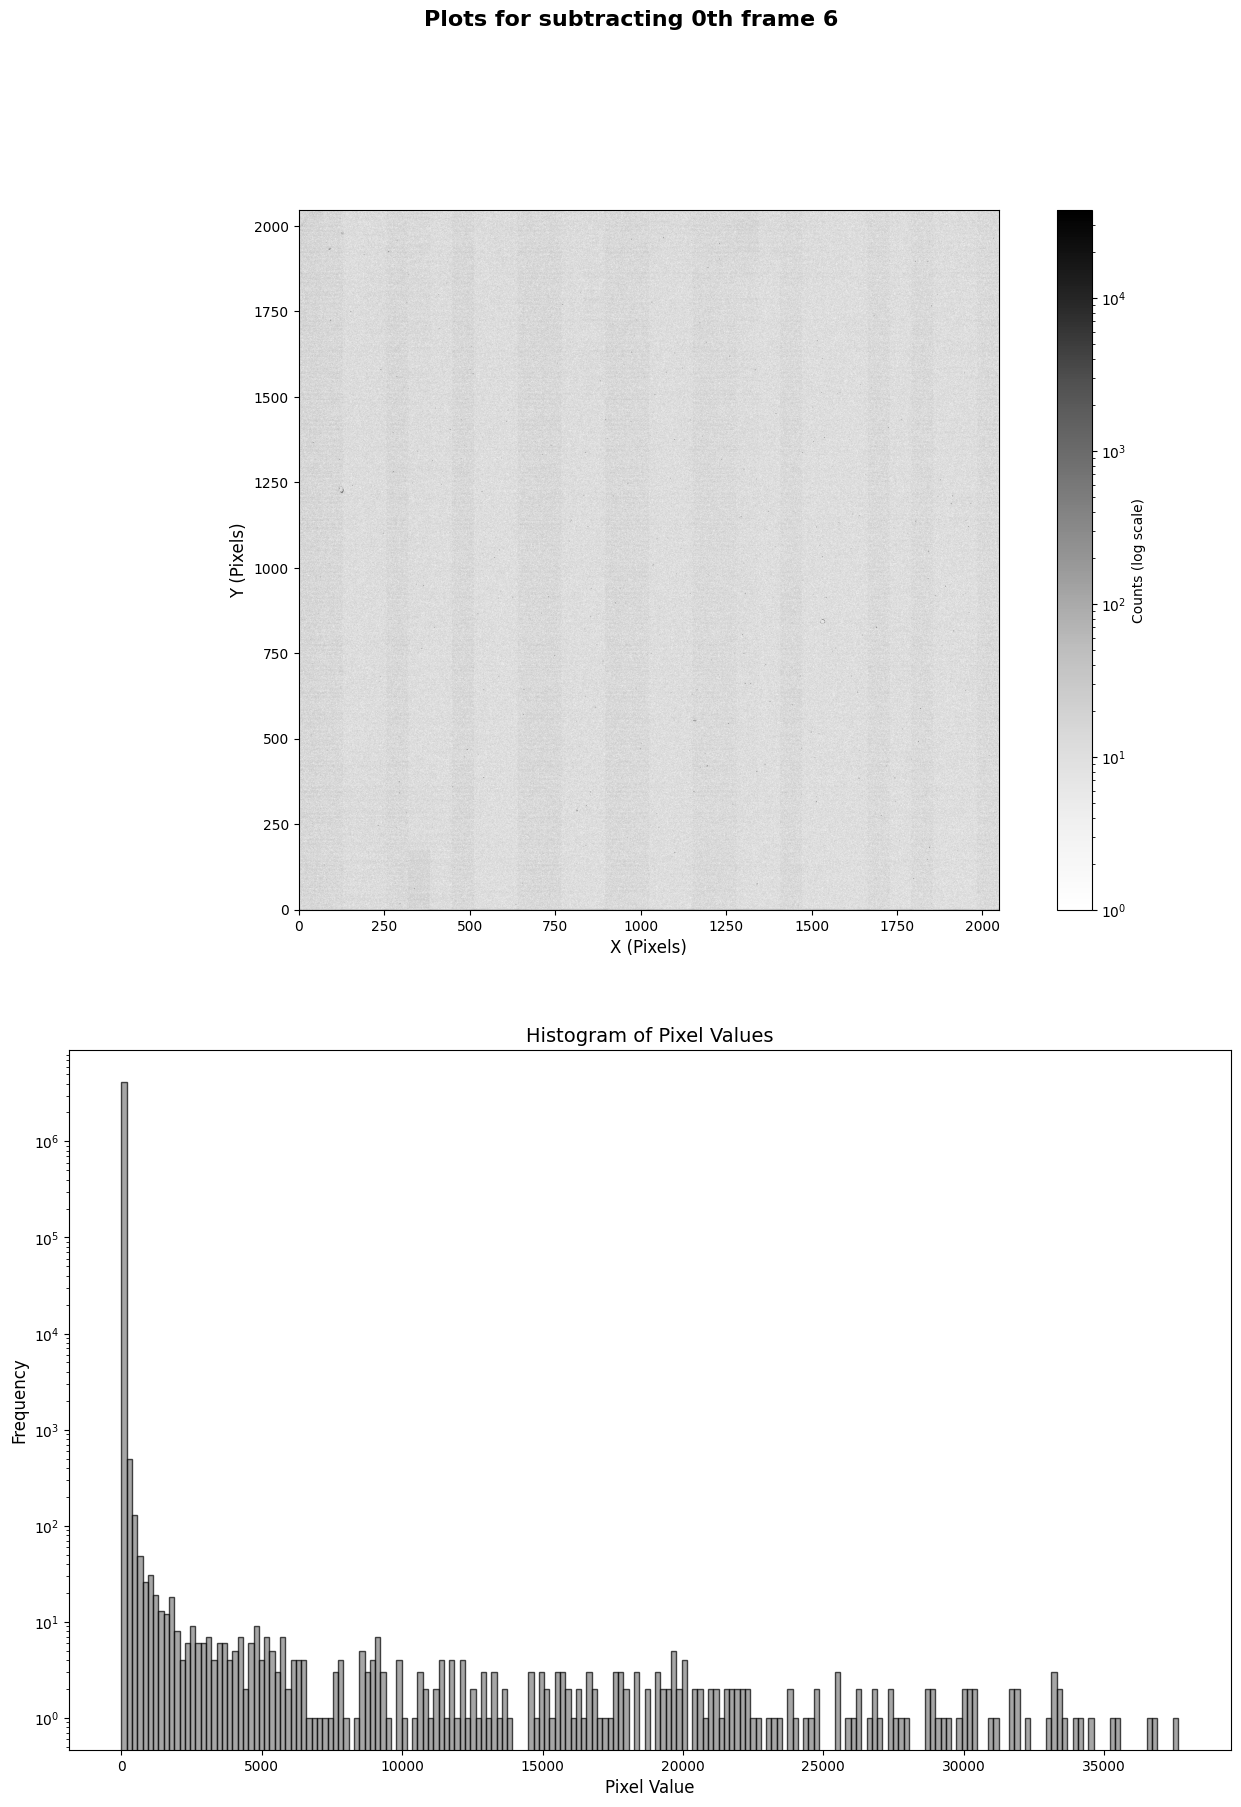

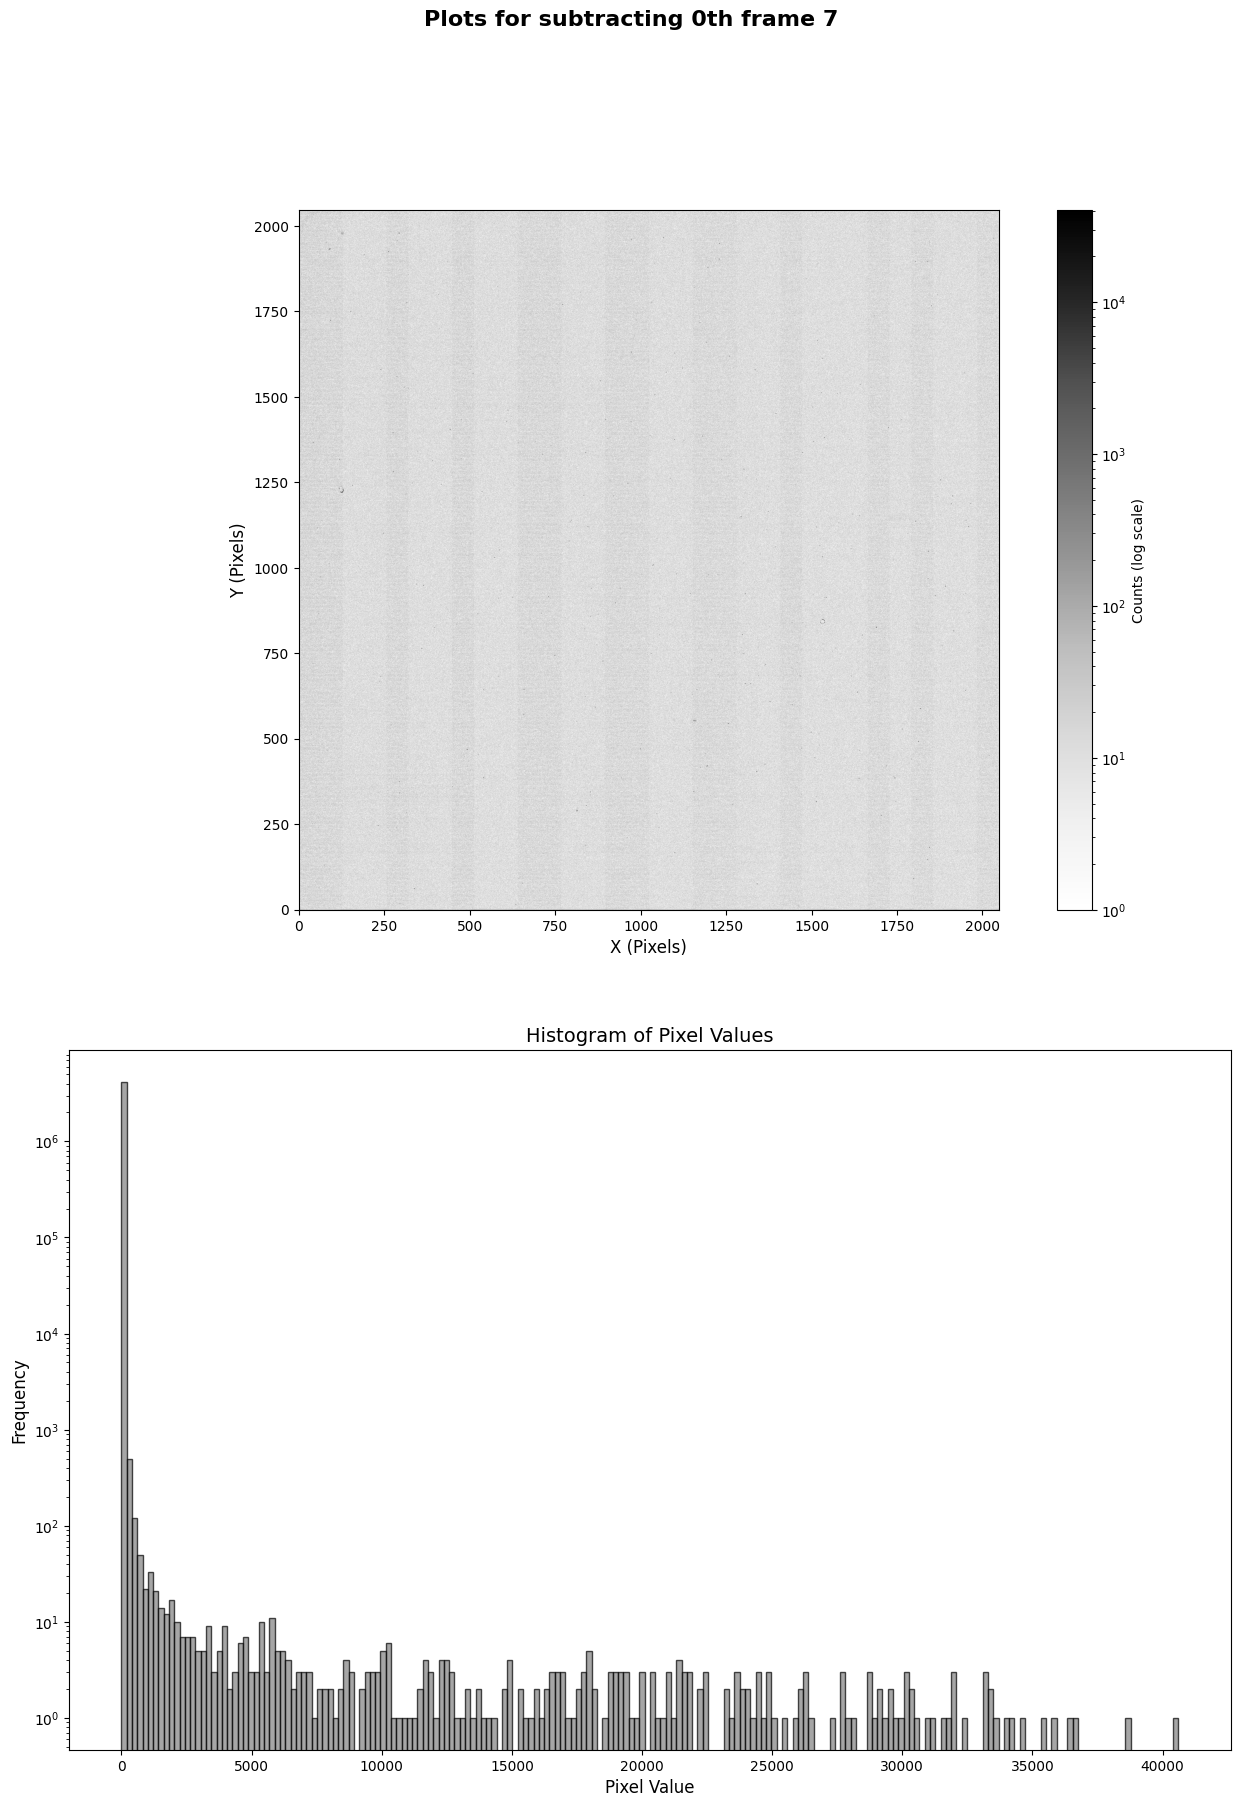

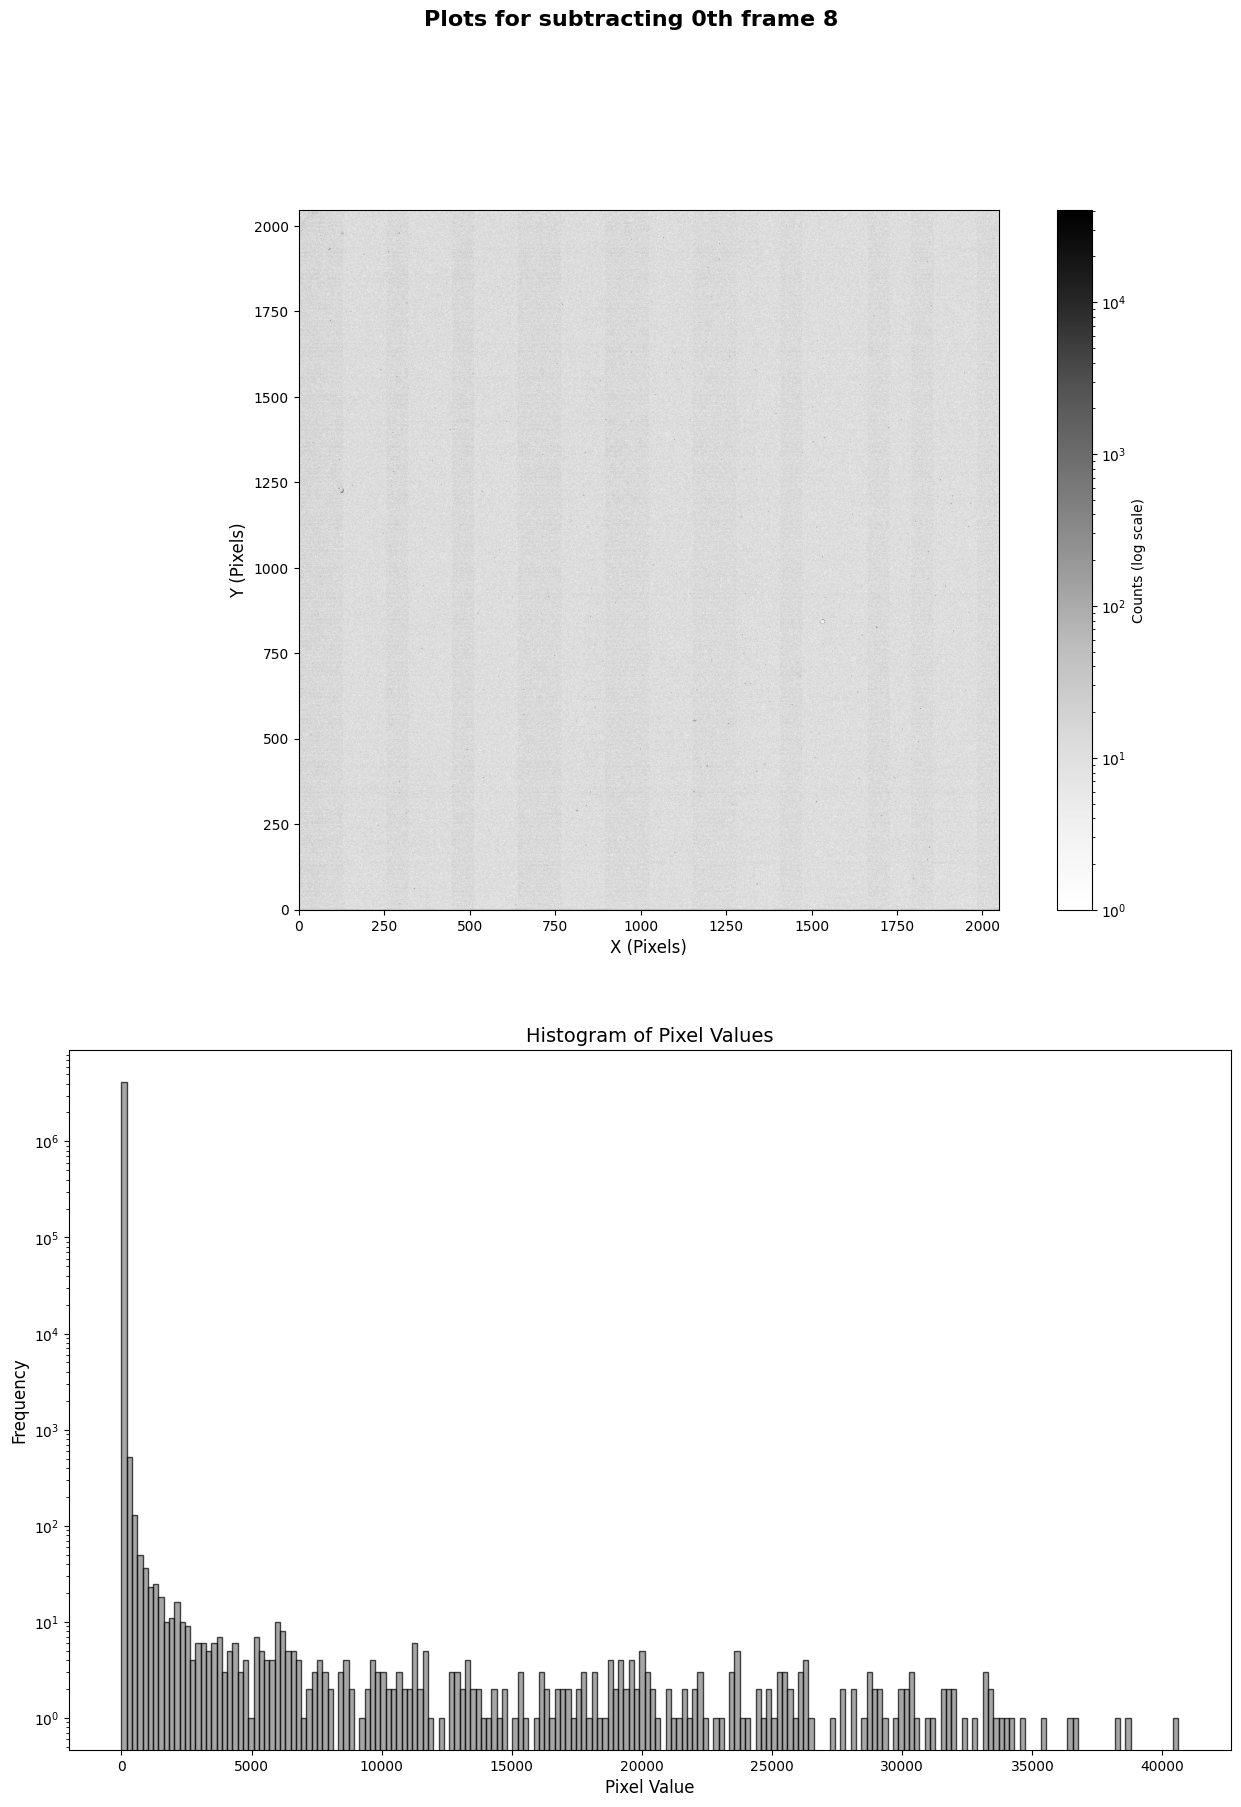

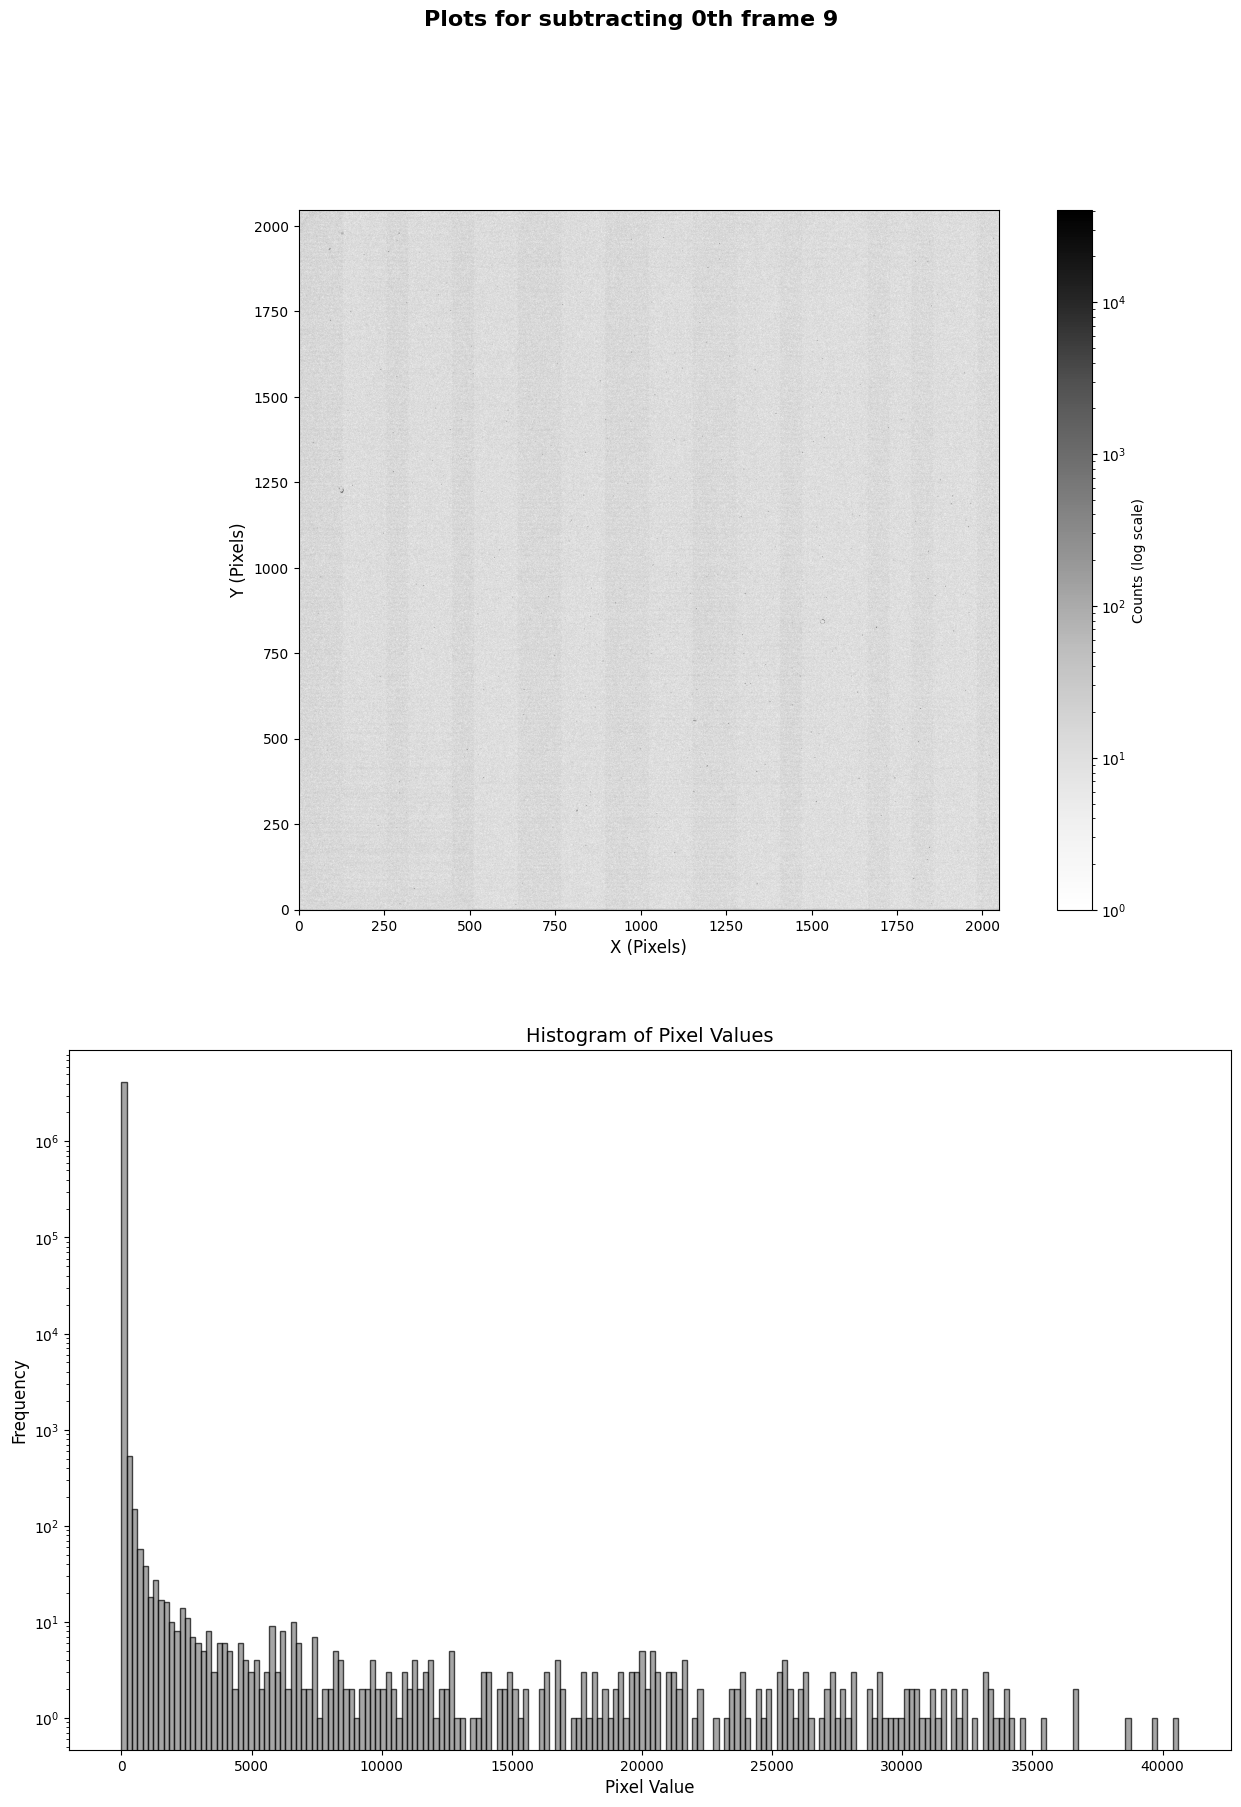

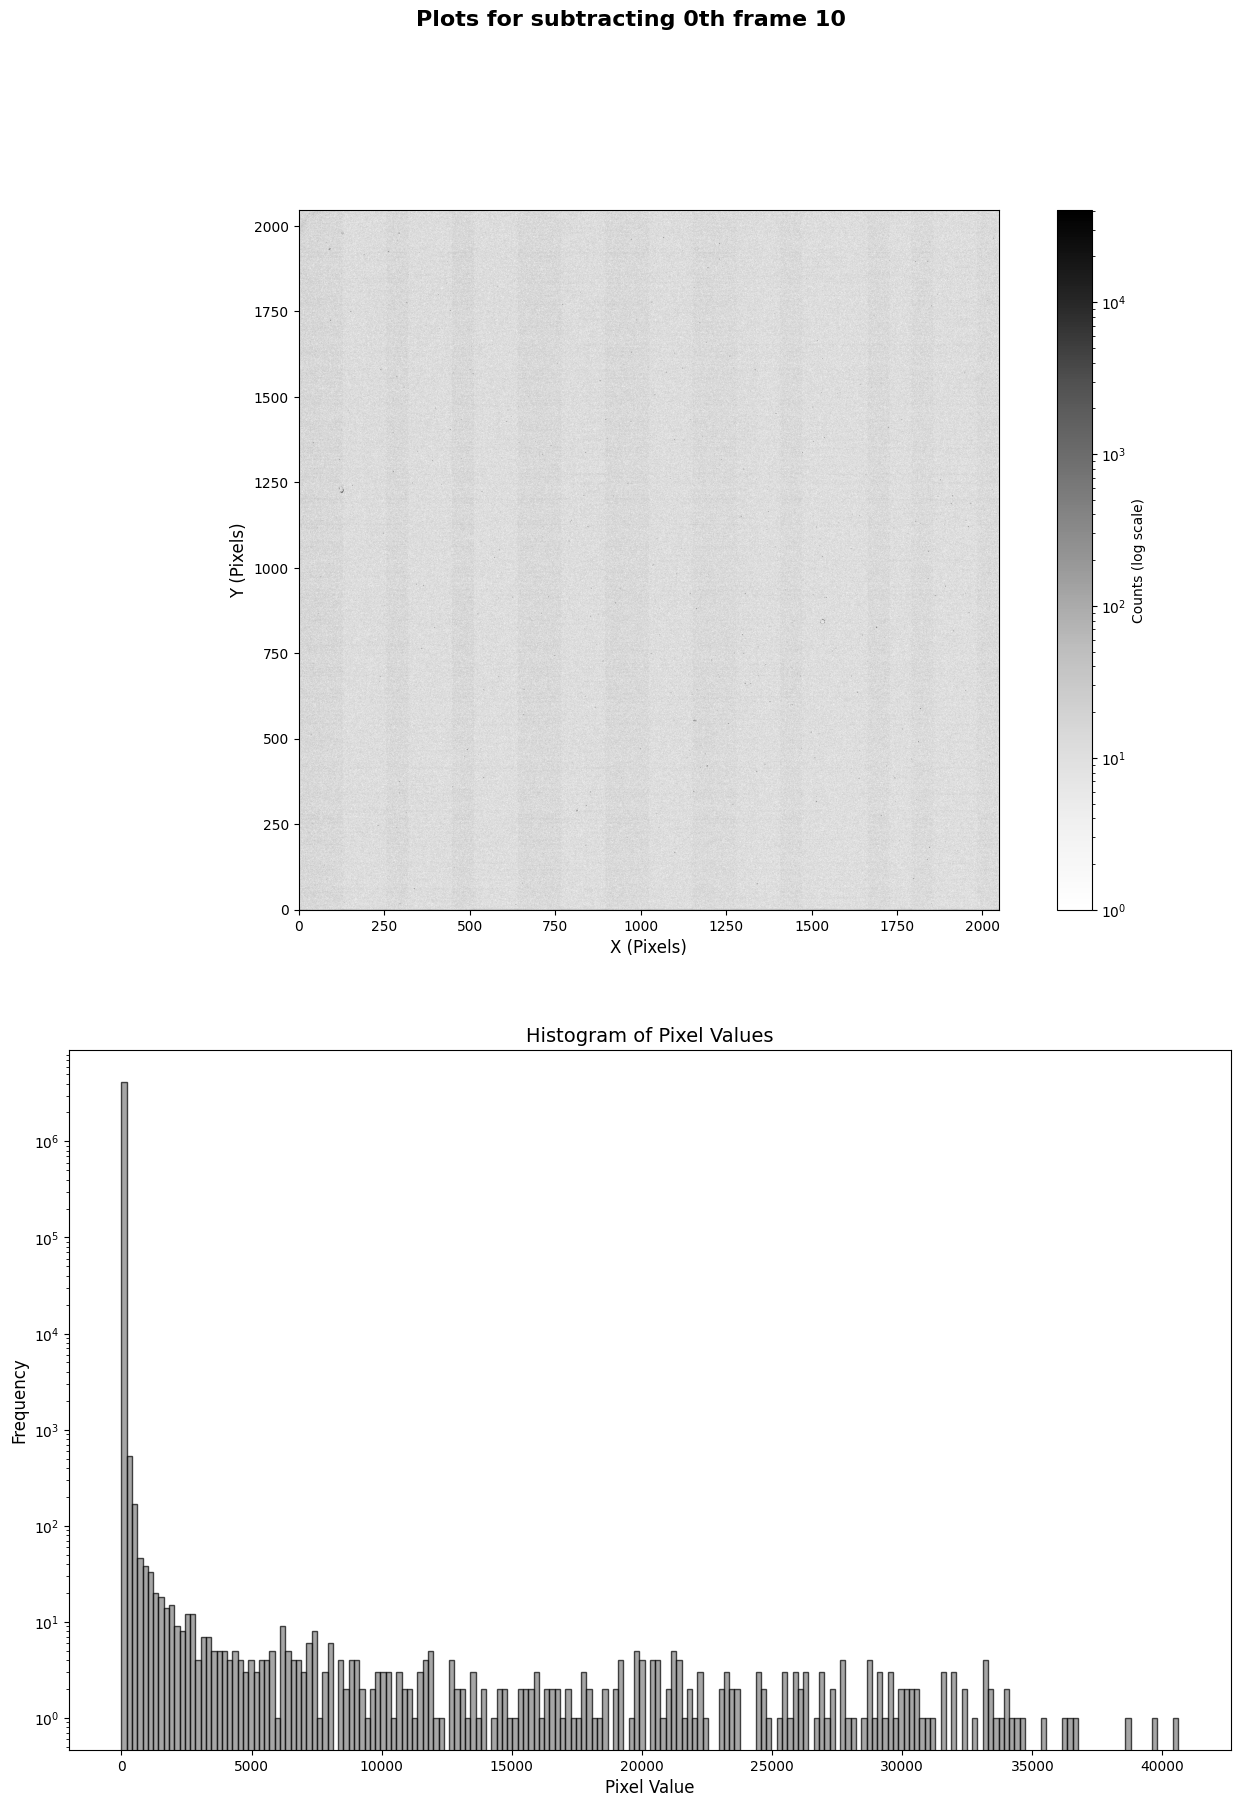

In [34]:
for i, frame_dif in enumerate(frame_difs):
    fig, axs = plt.subplots(2, 1, figsize=(15, 20))

    # Plot frame with log scale - add small value to avoid log(0)
    frame_dif_log = frame_dif + 1  # Add 1 to avoid log(0)
    im = axs[0].imshow(frame_dif_log, cmap='Greys', origin='lower', 
                       norm=LogNorm(vmin=1, vmax=frame_dif_log.max()))
    axs[0].set_xlabel('X (Pixels)', size=12)
    axs[0].set_ylabel('Y (Pixels)', size=12)
    plt.colorbar(im, ax=axs[0], label='Counts (log scale)')

    # Plot histogram of counts (already log scale)
    axs[1].hist(frame_dif.flatten(), bins=200, alpha=0.7, edgecolor='black', color='grey')
    axs[1].set_xlabel('Pixel Value', size=12)
    axs[1].set_ylabel('Frequency', size=12)
    axs[1].set_title('Histogram of Pixel Values', size=14)
    axs[1].set_yscale('log')

    plt.suptitle(f'Plots for subtracting 0th frame {i}', size=16, fontweight='bold')
    plt.show()

    if i == 10:

        break